# S&DE Atelier - Visual Analytics

# Assignment 1

**Due** April 6, 2023 @23:55 

**Contacts**: marco.dambros@usi.ch - carmen.armenti@usi.ch

---

The goal of this assignment is to use Python and Jupyter notebook to explore, analyze and visualize the datasets provided. To solve the assignment you should apply the knowledge you gained from the theoretical and practical lectures. In particular, when creating tabular or graphical representations you should apply the principles you learned from theoretical lectures and use the technologies presented during practical lectures. For what concerns the visualization library, we suggest to use the library presented in class (Seaborn, Matplotlib, Bokeh), but usage of other libraries (e.g., plotly) is also possible. You should submit a Jyputer notebook (named `SurenameName_Assignment1.ipynb`) that contains your solutions and the steps followed to arrive to these solutions. Please follow the structure of the assignment to solve the exercises.

The datasets you need to use are described in the **Datasets description** section.

In [1]:
# Uncomment the line below to install the exact dependency versions used to run this notebook

#%pip install --force-reinstall bokeh==3.1.0 ftfy==6.1.1 geopandas==0.12.2 matplotlib==3.7.1 numpy==1.24.2 pandas==1.5.3 seaborn==0.12.2 Shapely==2.0.1

# Due to the embedded bokeh cloropleth map, Jupyter-lab web version is required to run and show this notebook.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import bokeh
import ftfy
import matplotlib as mpl
import geopandas as gpd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import GeoJSONDataSource, ColumnDataSource, Legend, BoxSelectTool, HoverTool, TapTool, CustomJS
from bokeh.layouts import gridplot, column, row

In [2]:
# Show python version used to run this notebook
import sys

print(sys.version)

3.10.10 (main, Feb 16 2023, 02:55:02) [Clang 14.0.0 (clang-1400.0.29.202)]


## Exercise 1 - Data quality (15 points) 🧼

In the Used Cars dataset identify the missing and invalid values for the columns: `vehicle type`, `price`, `brand`, and `month of registration`. If needed, standardize the information and covert them to unique values. Please specify for each column the number of missing or invalid instances. The prices are in euros and the range of accepted prices is between €1'000 and €100'000.
Once you identified missing/invalid values for the given columns, remove all rows where one or more columns have invalid/missing data.
Show the steps that you follow to reach the solution. You can choose your preferred approach/technology to clean the dataset (e.g., Python vanilla, Pandas, OpenRefine). 

In [3]:
# UTF-8 decoding fails thanks to this byte
ftfy.guess_bytes(b'\xDC')

('Ü', 'sloppy-windows-1252')

In [4]:
# Reading using windows-1252 works
df_used = pd.read_csv("./datasets/used_cars_dataset.csv", encoding="windows-1252")
df_used.head()

dateCrawled                            name  seller offerType  \
0  2016-03-24 11:52:17                      Golf_3_1.6  privat   Angebot   
1  2016-03-24 10:58:45            A5_Sportback_2.7_Tdi  privat   Angebot   
2  2016-03-14 12:52:21  Jeep_Grand_Cherokee_"Overland"  privat   Angebot   
3  2016-03-17 16:54:04              GOLF_4_1_4__3TÜRER  privat   Angebot   
4  2016-03-31 17:25:20  Skoda_Fabia_1.4_TDI_PD_Classic  privat   Angebot   

   price abtest vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480   test         NaN                1993    manuell        0   golf   
1  18300   test       coupe                2011    manuell      190    NaN   
2   9800   test         suv                2004  automatik      163  grand   
3   1500   test  kleinwagen                2001    manuell       75   golf   
4   3600   test  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOfRegistration fuelType       brand notRepairedDamage  \
0     150000                    0   benzin  volkswagen               NaN   
1     125000                    5   diesel        audi                ja   
2     125000                    8   diesel        jeep               NaN   
3     150000                    6   benzin  volkswagen              nein   
4      90000                    7   diesel       skoda              nein   

           dateCreated  nrOfPictures  postalCode             lastSeen  
0  2016-03-24 00:00:00             0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00             0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00             0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00             0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00             0       60437  2016-04-06 10:17:21

In [5]:
# Here I check the types and the presence of missing values for each column
types = {}

for col in df_used.columns:
    t = set([type(x).__name__ if type(x) != float or not np.isnan(x) else 'nan' for x in df_used[col].unique()])
    types[col] = list(t)

types

{'dateCrawled': ['str'],
 'name': ['str'],
 'seller': ['str'],
 'offerType': ['str'],
 'price': ['int64'],
 'abtest': ['str'],
 'vehicleType': ['str', 'nan'],
 'yearOfRegistration': ['int64'],
 'gearbox': ['str', 'nan'],
 'powerPS': ['int64'],
 'model': ['str', 'nan'],
 'kilometer': ['int64'],
 'monthOfRegistration': ['int64'],
 'fuelType': ['str', 'nan'],
 'brand': ['str'],
 'notRepairedDamage': ['str', 'nan'],
 'dateCreated': ['str'],
 'nrOfPictures': ['int64'],
 'postalCode': ['int64'],
 'lastSeen': ['str']}

In [6]:
# Here I check for numeric values that have decimal digits (i.e. that are not integers).
for col in df_used.columns:
    print(f"{col}: {str([x for x in df_used[col].unique() if type(x) == float and not np.isnan(x) and round(x) != x])}")

# As shown, there are none, therefore we can use the Int64 dtype in numeric columns

dateCrawled: []
name: []
seller: []
offerType: []
price: []
abtest: []
vehicleType: []
yearOfRegistration: []
gearbox: []
powerPS: []
model: []
kilometer: []
monthOfRegistration: []
fuelType: []
brand: []
notRepairedDamage: []
dateCreated: []
nrOfPictures: []
postalCode: []
lastSeen: []


In [7]:
# Here I check if any column is unique to find potential candidates for the index
for col in df_used.columns:
    print(f"{col}: {df_used[col].is_unique}")

# None are unique, so I use the default numeric index

dateCrawled: False
name: False
seller: False
offerType: False
price: False
abtest: False
vehicleType: False
yearOfRegistration: False
gearbox: False
powerPS: False
model: False
kilometer: False
monthOfRegistration: False
fuelType: False
brand: False
notRepairedDamage: False
dateCreated: False
nrOfPictures: False
postalCode: False
lastSeen: False


In [8]:
# I read again the dataset using the information about the column types I found
df_used = pd.read_csv("./datasets/used_cars_dataset.csv", encoding="windows-1252", dtype={
    'dateCrawled': str,
    'name': pd.StringDtype(),
    'seller': pd.StringDtype(),
    'offerType': pd.StringDtype(),
    'price': pd.Int64Dtype(),
    'abtest': pd.StringDtype(),
    'vehicleType': pd.StringDtype(),
    'yearOfRegistration': pd.Int64Dtype(),
    'gearbox': pd.StringDtype(),
    'powerPS': pd.Int64Dtype(),
    'model': pd.StringDtype(),
    'kilometer': pd.Int64Dtype(),
    'monthOfRegistration': pd.Int64Dtype(),
    'fuelType': pd.StringDtype(),
    'brand': pd.StringDtype(),
    'notRepairedDamage': pd.StringDtype(),
    'dateCreated': pd.StringDtype(),
    'nrOfPictures': pd.Int64Dtype(),
    'postalCode': pd.Int64Dtype(),
    'lastSeen': pd.StringDtype()
})
df_used.head()

dateCrawled                            name  seller offerType  \
0  2016-03-24 11:52:17                      Golf_3_1.6  privat   Angebot   
1  2016-03-24 10:58:45            A5_Sportback_2.7_Tdi  privat   Angebot   
2  2016-03-14 12:52:21  Jeep_Grand_Cherokee_"Overland"  privat   Angebot   
3  2016-03-17 16:54:04              GOLF_4_1_4__3TÜRER  privat   Angebot   
4  2016-03-31 17:25:20  Skoda_Fabia_1.4_TDI_PD_Classic  privat   Angebot   

   price abtest vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480   test        <NA>                1993    manuell        0   golf   
1  18300   test       coupe                2011    manuell      190   <NA>   
2   9800   test         suv                2004  automatik      163  grand   
3   1500   test  kleinwagen                2001    manuell       75   golf   
4   3600   test  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOfRegistration fuelType       brand notRepairedDamage  \
0     150000                    0   benzin  volkswagen              <NA>   
1     125000                    5   diesel        audi                ja   
2     125000                    8   diesel        jeep              <NA>   
3     150000                    6   benzin  volkswagen              nein   
4      90000                    7   diesel       skoda              nein   

           dateCreated  nrOfPictures  postalCode             lastSeen  
0  2016-03-24 00:00:00             0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00             0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00             0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00             0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00             0       60437  2016-04-06 10:17:21

From here onwards, I investigate the missing and invalid values. If I find any invalid values, I replace them with `<NA>` to encode them as the missing values. This makes it easy to count and drop them all in one go.

In [9]:
# I look at the values of the indicated columns to find odd values. 
# Indeed, some brand values use mixed case (BMW) and spaces ('bmw '). Additionally, 
# a month of registration = 0 does not make sense when the other values are in the
# 1-12 range.
cols = ["vehicleType", "brand", "monthOfRegistration"]

def print_col(col: str):
    print(f"{col}: {str(sorted(df_used[col].unique(), key=lambda x: str(x)))}")

for col in cols:
    print_col(col)


vehicleType: [<NA>, 'andere', 'bus', 'cabrio', 'coupe', 'kleinwagen', 'kombi', 'limousine', 'suv']
brand: ['BMW', 'alfa_romeo', 'audi', 'bmw', 'bmw ', 'chevrolet', 'chrysler', 'citroen', 'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai', 'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda', 'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot', 'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart', 'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo']
monthOfRegistration: [0, 1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9]


In [10]:
# Some brands are written using mixed case or with spaces, hence here I normalize to stripped lowercase
df_used.brand = df_used.brand.apply(lambda x: x if type(x) is not str else x.lower().strip())
print_col("brand")

# monthOfRegistration=0 is invalid, hence i mark it as NaN
df_used[df_used.monthOfRegistration == 0] = np.nan
print_col("monthOfRegistration")

brand: ['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen', 'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai', 'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda', 'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot', 'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart', 'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo']
monthOfRegistration: [1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9, <NA>]


In [11]:
# This column only has 'ja' and 'nein' as non-missing values, we can convert it to a boolean
print_col("notRepairedDamage")

notRepairedDamage: [<NA>, 'ja', 'nein']


In [12]:
# Hence we map the column to boolean values
df_used.notRepairedDamage = df_used.notRepairedDamage.map({'ja': True, 'nein': False})

In [13]:
# Prices not in the 1000-100'000 range are invalid, hence I convert them to NaN
df_used.loc[(df_used.price.isna()) | (df_used.price < 1000) | (df_used.price > 100_000), "price"] = np.nan

In [14]:
# This reports the number of values in each column that are missing or invalid
df_used.isna().sum()

dateCrawled             37675
name                    37675
seller                  37675
offerType               37675
price                  101662
abtest                  37675
vehicleType             60491
yearOfRegistration      37675
gearbox                 47998
powerPS                 37675
model                   51550
kilometer               37675
monthOfRegistration     37675
fuelType                57286
brand                   37675
notRepairedDamage       87440
dateCreated             37675
nrOfPictures            37675
postalCode              37675
lastSeen                37675
dtype: int64

In [15]:
# Here I drop the missing values and i re-enumerate all the rows with the automatic numeric index
df_used = df_used.dropna().reset_index(drop=True)

## Exercise 2 - Data analysis (20 points) 📊

1. We consider the norm to be that, for a given type of vehicle, on average the price of diesel is greater than the one of benzine. Provide a representation of the data which shows if, and to which extent, the various vehicle types conform to the norm.
What relationship are you showing? Please justify the choice of the representation and your answer.
2. Find an appropriate way to show and compare the range of prices for the following `brand`: **mercedes_benz**, **fiat**, **volvo**, **alfa_romeo** and **lancia**. Create a suitable graphical representation of this data. What kind of relationship are you showing? Describe what can be understood from the plot. Please justify your answer and your choice of the graphical representation.

<aside>
💡 N.B. In this section you should work on the clean Used Cars dataset, without the missing and invalid data.
</aside>

### 2.1

By interpreting the following requirement:

> on average the price of diesel is greater than the one of benzine

as meaning that we expect the average price of diesel cars to be greater than the average cars of _benzin_ cars for each car type, I choose to represent the relationship between each car type and the difference of these average values (i.e. $y=E({\text{diesel}}) - E({\text{benzin}})$, where a positive value of $y$ would confirm the expectation).

To represent this relationship I choose to use a simple bar chart plotting these differences. I choose to plot a single series for the difference instead of both series for both fuel types to further focus the reader on the difference and not the values. Additionally, plotting the difference only makes comparing the difference value between car types easier as they are all aligned with the origin.

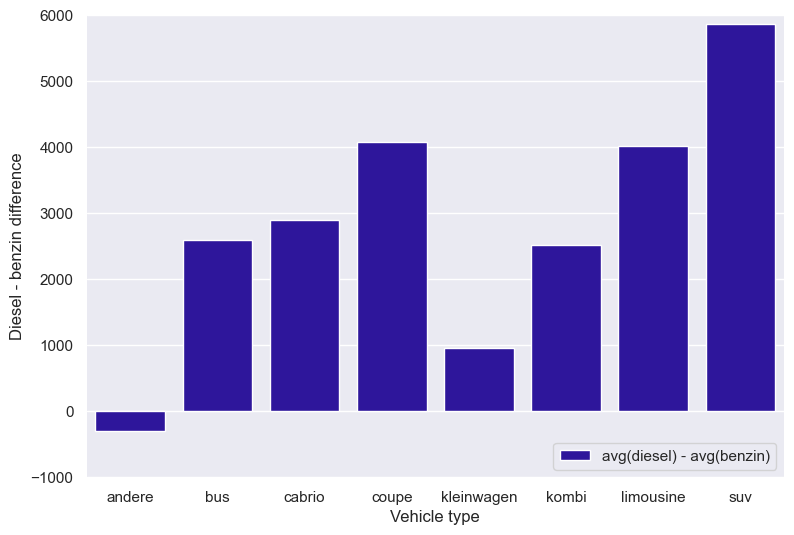

In [16]:
df_diff = df_used \
    .loc[(df_used.fuelType == 'benzin') | (df_used.fuelType == 'diesel'), ['vehicleType', 'fuelType', 'price']]\
    .groupby(['vehicleType', 'fuelType']) \
    .mean() \
    .sort_values(['vehicleType', 'fuelType'], ascending=[True, True]) \
    .groupby('vehicleType') \
    .diff() \
    .reset_index() \
    .set_index('vehicleType')

df_diff = df_diff.loc[df_diff.fuelType == 'diesel', ['price']].rename({'price': 'diffPrice'}, axis=1).reset_index()

sns.set_theme(palette="hls")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(9, 6))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="vehicleType", y="diffPrice", data=df_diff,
            label="avg(diesel) - avg(benzin)", color=sns.xkcd_rgb["ultramarine"])

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Diesel - benzin difference", ylim=[-1000, 6000], 
       xlabel="Vehicle type")
sns.despine(left=True, bottom=True)

### 2.2

To compare the range of prices between car brands, I choose to plot the distribution of car prices for each car brand. To achieve this, I choose to use a variant of the box plot called boxen plot, which ditches whiskers in favour of showing octiles, 16-tiles and so on with coloured rectangles similar to the inner quartiles with exponentially smaller heights.

From the plot we can see that the `mercedes_benz` car type has the highest median price, and it also has the most right skewed price distribution out of all car brands. `volvo` has the second-highest average and also a skewed price distribution. Both `lancia` and `fiat` are instead more uniformly distributed towards lower prices, while `alfa_romeo` has a similar distribution however with some skewing towards the expensive side. [`trabant`](https://www.youtube.com/watch?v=npMKIUTa3uI) is the cheapest car type.

I choose to use a box-plot style graph as it is an effective representation to show some salient characterististics for one-dimensional distributions, such as the median and the quartiles (25% percentile, 75% percentile). I choose a `boxenplot` in particular to better capture the right-skewedness of some distributions with the additional percentiles considered by the octiles (87.5%), 16-tiles (93.75%) and so on exponentially.

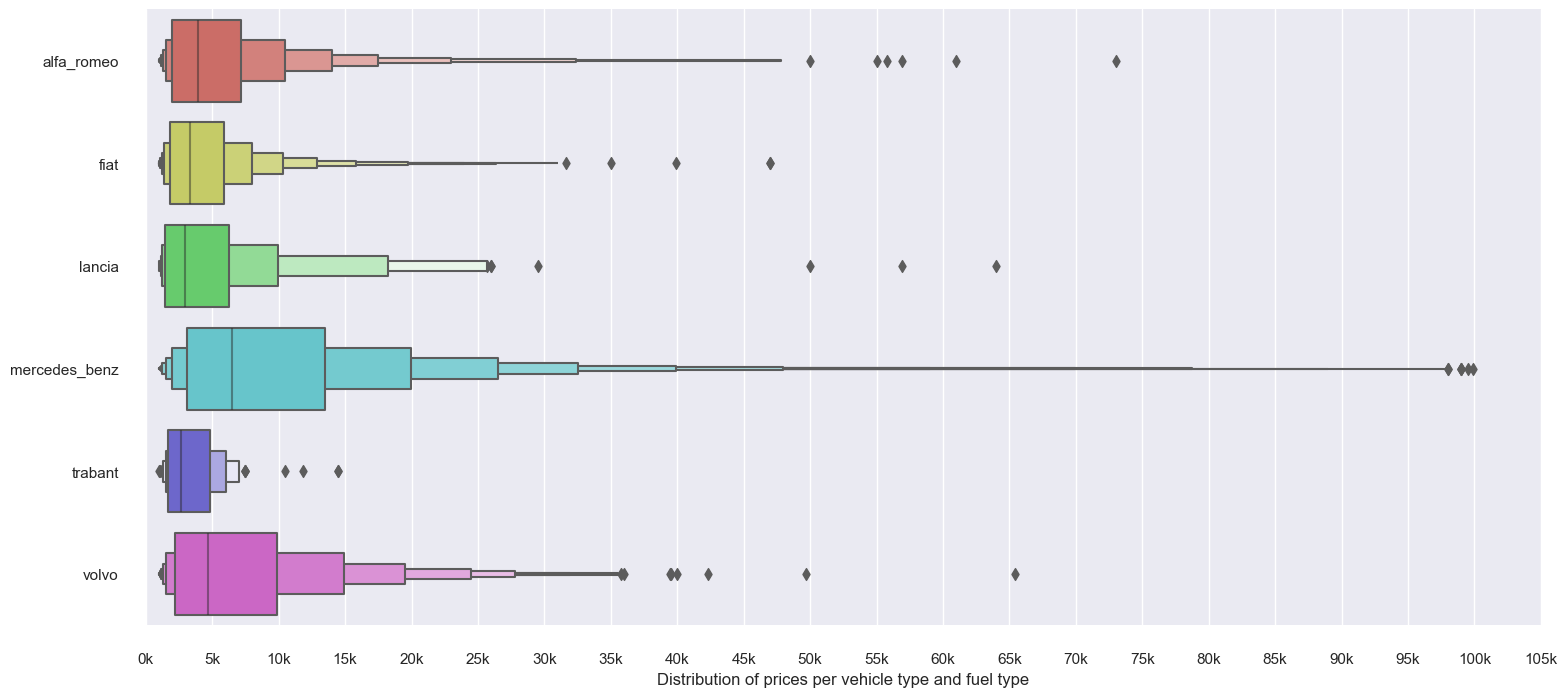

In [17]:
brands = ['mercedes_benz', 'fiat', 'volvo', 'alfa_romeo', 'lancia', 'trabant']

df_price = df_used \
    .loc[df_used.brand.isin(brands), ['brand', 'price']] \
    .sort_values('brand', ascending=True)

sns.set_theme(palette="hls")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(18, 8))

mkfunc = lambda x, pos: '%1.0fk' % (x * 1e-3)
mkformatter = mpl.ticker.FuncFormatter(mkfunc)
ax.xaxis.set_major_formatter(mkformatter)

# Draw a nested boxplot to show bills by day and time
sns.boxenplot(y="brand", x="price", data=df_price)

ax.set(ylabel="", xlim=[0, 100000], xticks=range(0, 105001, 5000),
       xlabel="Distribution of prices per vehicle type and fuel type")
       
sns.despine(offset=10, trim=True)

## Exercise 3 - Data analysis (20 points) 📊

The following graph represents the financial meltdown's impact on banks since the 2008 financial crisis began, and compares the market value of each bank as of 2007 - in blue - and 2009 - in green. The **main** purpose of the graph is to show the loss of each bank after the financial crisis and to enlight the little decline pre-versus-post meltdown of J.P. Morgan; the **secondary** purpose is to provide a sense of the relative sizes of the banks in terms of market value (e.g., J.P. Morgan is not a small bank).
Is there a better solution to achieve these two goals? How would you compare both the remaining market value of each bank after the loss caused by the crisis and their decline?

List all the problems that you detect in the design of this graph with respect to the quantive message the graph is supposed to deliver.

Propose and implement a different graph that delivers effectively the message.

Use the data in the ‘*market_value_decline’* dataset to populate the new graph.

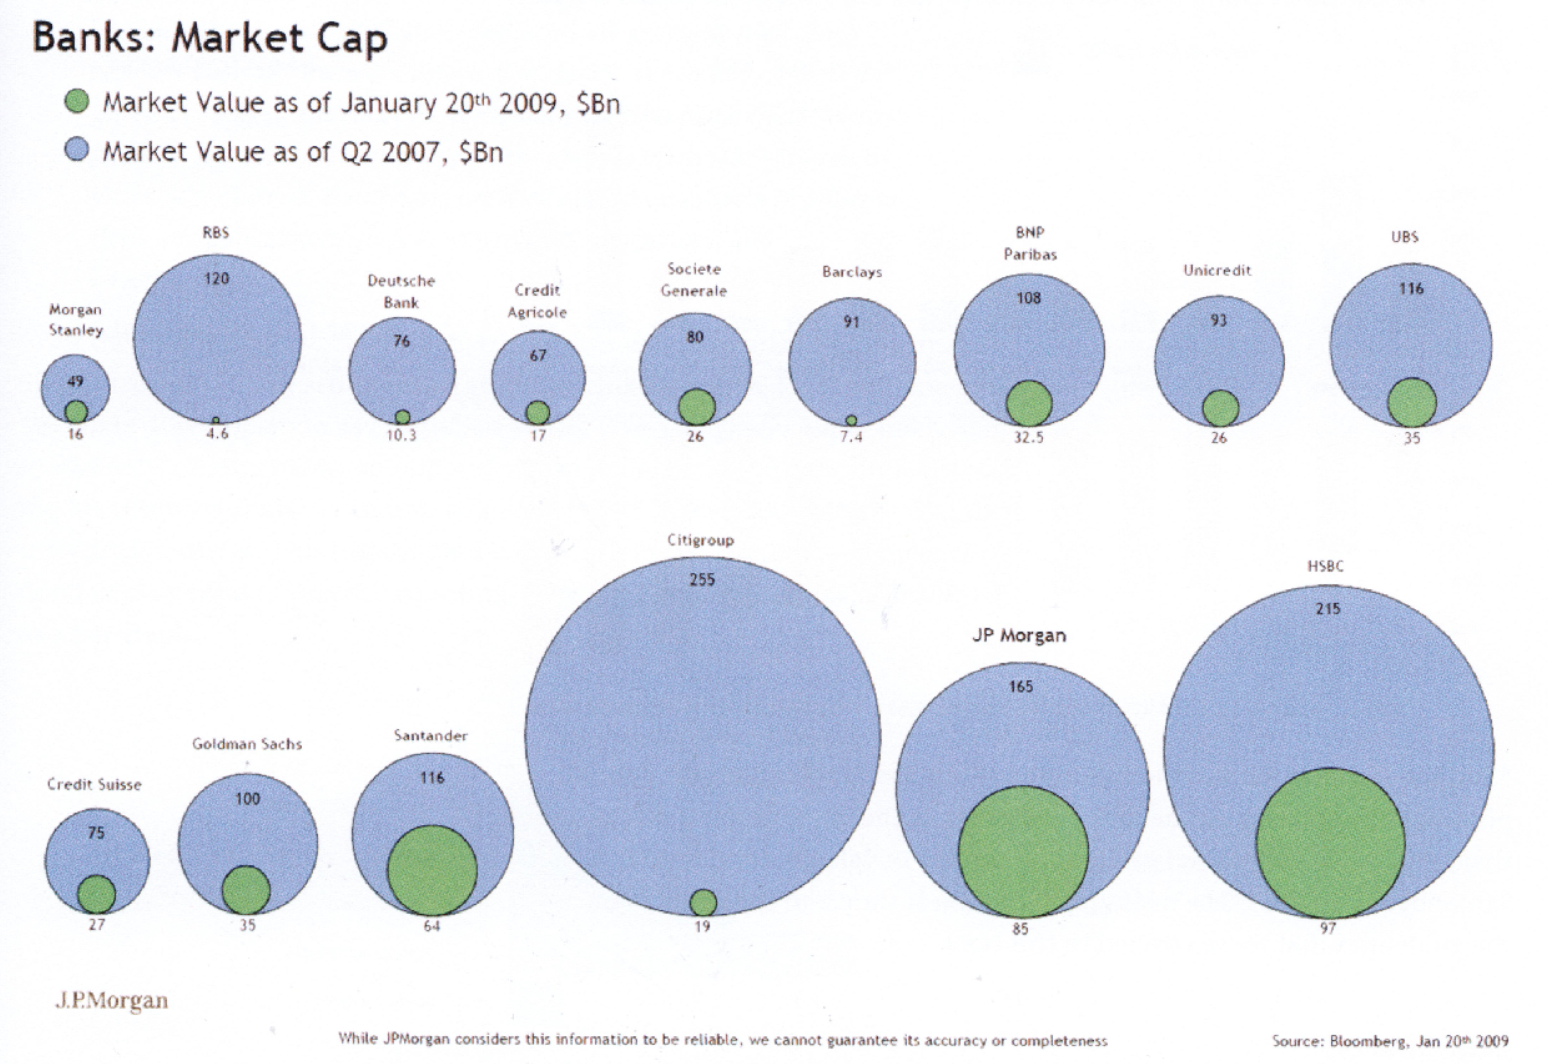

<!-- List all the problems that you detect in the design of this graph with respect to the quantive message the graph is supposed to deliver. -->
The given graph is not suited to show quantitative values because it relies on the areas of two-dimensional objects to convey the magnitude of the values it shows. Humans are not suited to understand at a glance the difference between the areas of two objects, instead being capable to grasp much one-dimensional differences, like length. This is why the use of a bar chart would have been more suited to show these quantitative values.

The given graph does not provide a convenient way to show the market decline of each bank. As we are required to mentally compute the difference of market value before and after the stock market crash, it is hard to compare the banks to see which one has lost the least or the most value. 

<!-- How would you compare both the remaining market value of each bank after the loss caused by the crisis and their decline? -->
As we want to convey that JP Morgan has one of the lowest relative market value differences, I would plot directly this difference as another bar chart.

<!-- Is there a better solution to achieve these two goals? -->
<!-- Propose and implement a different graph that delivers effectively the message. -->
We can implement a better graph with a table lens bar chart showing both the relative market value decrease for each bank and the pre- and post-market collapse market values. The left side shows the former message (i.e. fulfilling the main purpose), while the right side shows the latter message (i.e. fulfilling the secondary purpose).

In [18]:
df_m = pd.read_csv("./datasets/market_value_decline.csv").rename(columns={
       'Unnamed: 0': 'bank',
       'market_value_2007': '2007',
       'market_value_2009': '2009'
})

df_mkt = df_m
df_mkt["diff"] = 100 * (df_mkt['2009'] - df_mkt['2007']) / df_mkt['2007']
df_mkt = df_mkt.sort_values(['diff'], ascending=False)

# sort source DF according to new order by diff
df_m = df_m.reindex(df_mkt.index)

In [19]:
df_mval = pd.melt(df_m.loc[:, ['bank', '2007', '2009']], id_vars=['bank'], var_name='year', value_name='market_value')

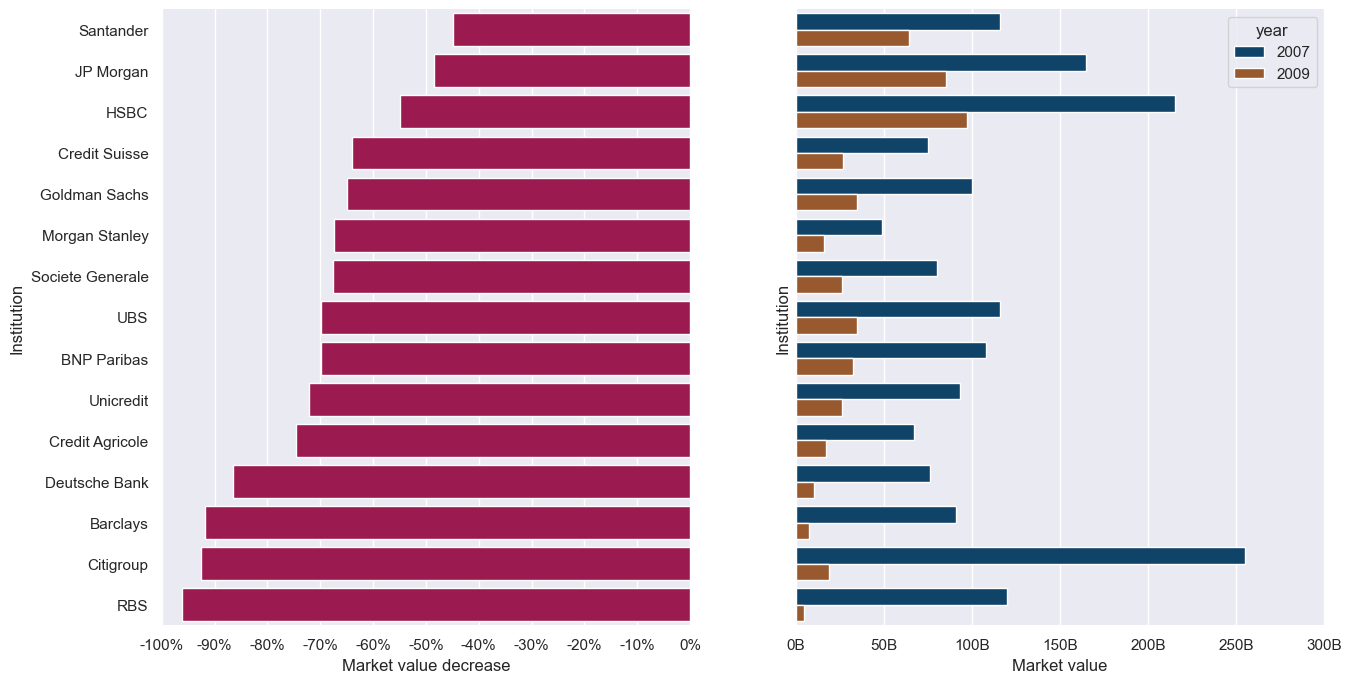

In [20]:
sns.set_theme(palette="hls")

# Initialize the matplotlib figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

ax2.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.0fB' % (x)))
ax1.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%.0f%%' % (x)))

sns.barplot(y="bank", x="diff", data=df_mkt, ax=ax1, color=sns.xkcd_rgb["purplish red"])
sns.barplot(
    data=df_mval, ax=ax2,
    x="market_value", y="bank", hue="year",
    palette=[sns.xkcd_rgb["prussian blue"], sns.xkcd_rgb["sienna"]]
)

# Add a legend and informative axis label
ax2.set(ylabel="Institution", xlim=[0, 300],
       xlabel="Market value")
ax1.set(ylabel="Institution", xlim=[-1, 0], xticks=range(-100, 1, 10),
       xlabel="Market value decrease")
sns.despine(left=True, bottom=True)

## Exercise 4 - Data visualisation and exploration (30 points) 🔍

You'll need to work with the *'airports'* and *‘airports-delays’* datasets. Examine the datasets and perform cleansing if needed, before performing the exercise.

1. Create a dataframe that provides, for each country, <del>the mean of flights delayed</del>. Display these information by binning the flights delayed in 6 bins. The resulting dataframe should have the countries as rows and the 6 bins as columns. For this exercise you cannot use pivot_table but only groupby. 

<span style="color: red">According to answer of question to professor:</span>
> Bin by delay_duration value, compute delay mean per-bin per-country 

2. Create a dataframe from ‘a*irports-delays’* which shows for each continent and country:
    1. max, min and mean of ‘**delay_duration**’;
    2. mean, sum of ‘**flights_cancelled**’;
    3. mean, sum of ‘**flights_delayed**’;
    4. mean, sum of ‘**flights_planned**.

3. Show a representation of the relationship between the number of flights planned and the number of flights delayed for each continent. It should be possible to see the relationship and the presence of outliers for each continent. What do you observe? You may want to display the median of the values for a better explaination.

In [21]:
df_del = pd.read_csv("./datasets/airports-delays.csv", index_col='ID', sep=";", na_values=['\\N']) \
    .dropna(subset=['tz_database_timezone'])

In [22]:
def tz_to_continent(tz: str) -> str:
    tz_mappings = {
        'Asia/': 'Asia',
        'Africa/': 'Africa',
        'America/': 'America',
        'Europe/': 'Europe',
        'Australia/': 'Oceania',
        'Pacific/': 'Oceania',
        'Antarctica/': 'Antarctica',
        'Arctic/Longyearbyen': 'Europe',
        'Atlantic/Azores': 'Europe',
        'Atlantic/Bermuda': 'America',
        'Atlantic/Canary': 'Africa',
        'Atlantic/Cape_Verde': 'Africa',
        'Atlantic/Faeroe': 'Europe',
        'Atlantic/Reykjavik': 'Europe',
        'Atlantic/St_Helena': 'Africa',
        'Atlantic/Stanley': 'America',
        'Indian/Antananarivo': 'Africa',
        'Indian/Chagos': 'Asia',
        'Indian/Christmas': 'Oceania',
        'Indian/Cocos': 'Oceania',
        'Indian/Comoro': 'Africa',
        'Indian/Mahe': 'Africa',
        'Indian/Maldives': 'Asia',
        'Indian/Mauritius': 'Africa',
        'Indian/Mayotte': 'Africa',
        'Indian/Reunion': 'Africa',
    }
    if type(tz) != str:
        raise ValueError("tz not str")
    to_return = [v for (k, v) in tz_mappings.items() if tz.startswith(k)]
    if len(to_return) == 0:
        raise ValueError(f"'{tz}' no continent found")
    return to_return[0]

df_del["continent"] = df_del["tz_database_timezone"].apply(tz_to_continent)

In [23]:
df_4_1 = df_del.copy()

# The following statements bins the data by the value of delay_duration.
# The bins are chosen as equally-spaced percentile values of the data. This is done to 
# better distribute the data between bins, as it is quite skewed towards low values
df_4_1["delay_duration_bin"] = pd.qcut(df_del.delay_duration, 6)

# The dataframe will contain countries as row indices, the 6 bins as columns and values
# corresponding to the mean delay_duration per country, per bin. When no delay_duration 
# falls in a particular bin for some country, that bin has a value of 0
df_4_1 = df_4_1.loc[:, ['country', 'delay_duration', 'delay_duration_bin']] \
    .groupby(['country', 'delay_duration_bin']) \
    .mean() \
    .fillna(0) \
    .reset_index() \
    .pivot(index='country', columns='delay_duration_bin', values='delay_duration') 

df_4_1.head()

delay_duration_bin  (15.999, 30.0]  (30.0, 35.0]  (35.0, 41.0]  (41.0, 47.0]  \
country                                                                        
Afghanistan                    0.0      0.000000          0.00          44.0   
Albania                        0.0      0.000000          0.00           0.0   
Algeria                       26.5     33.857143         38.75          43.0   
American Samoa                 0.0      0.000000          0.00          43.0   
Angola                        28.0     35.000000         36.00          45.0   

delay_duration_bin  (47.0, 59.0]  (59.0, 850.0]  
country                                          
Afghanistan             0.000000           60.0  
Albania                56.000000            0.0  
Algeria                51.200000           73.0  
American Samoa         48.000000            0.0  
Angola                 51.666667            0.0

In [24]:
# 4.2
df_4_2 = df_del.loc[:, ['country', 'continent', 'delay_duration', 'flights_cancelled', 'flights_delayed', 'flights_planned']] \
    .sort_values(['continent', 'country']) \
    .groupby(['continent', 'country']) \
    .agg(dur_min=('delay_duration', 'min'), \
        dur_mean=('delay_duration', 'mean'), \
        dur_max=('delay_duration', 'max'), \
        cancelled_sum=('flights_cancelled', 'sum'), \
        cancelled_mean=('flights_cancelled', 'mean'), \
        delayed_sum=('flights_delayed', 'sum'), \
        delayed_mean=('flights_delayed', 'mean'), \
        planned_sum=('flights_planned', 'sum'), \
        planned_mean=('flights_planned', 'mean'))
    
df_4_2.head()

dur_min   dur_mean  dur_max  cancelled_sum  \
continent country                                                    
Africa    Algeria          26.0  43.739130     82.0              6   
          Angola           28.0  42.714286     53.0              9   
          Benin            69.0  69.000000     69.0              0   
          Burkina Faso     35.0  35.000000     35.0              0   
          Cameroon         28.0  51.250000     83.0              3   

                        cancelled_mean  delayed_sum  delayed_mean  \
continent country                                                   
Africa    Algeria              0.26087          360     15.652174   
          Angola               1.12500           97     12.125000   
          Benin                0.00000            7      7.000000   
          Burkina Faso         0.00000           18     18.000000   
          Cameroon             0.75000           61     15.250000   

                        planned_sum  planned_mean  
continent country                                  
Africa    Algeria              1864     81.043478  
          Angola                472     59.000000  
          Benin                  28     28.000000  
          Burkina Faso           65     65.000000  
          Cameroon              339     84.750000

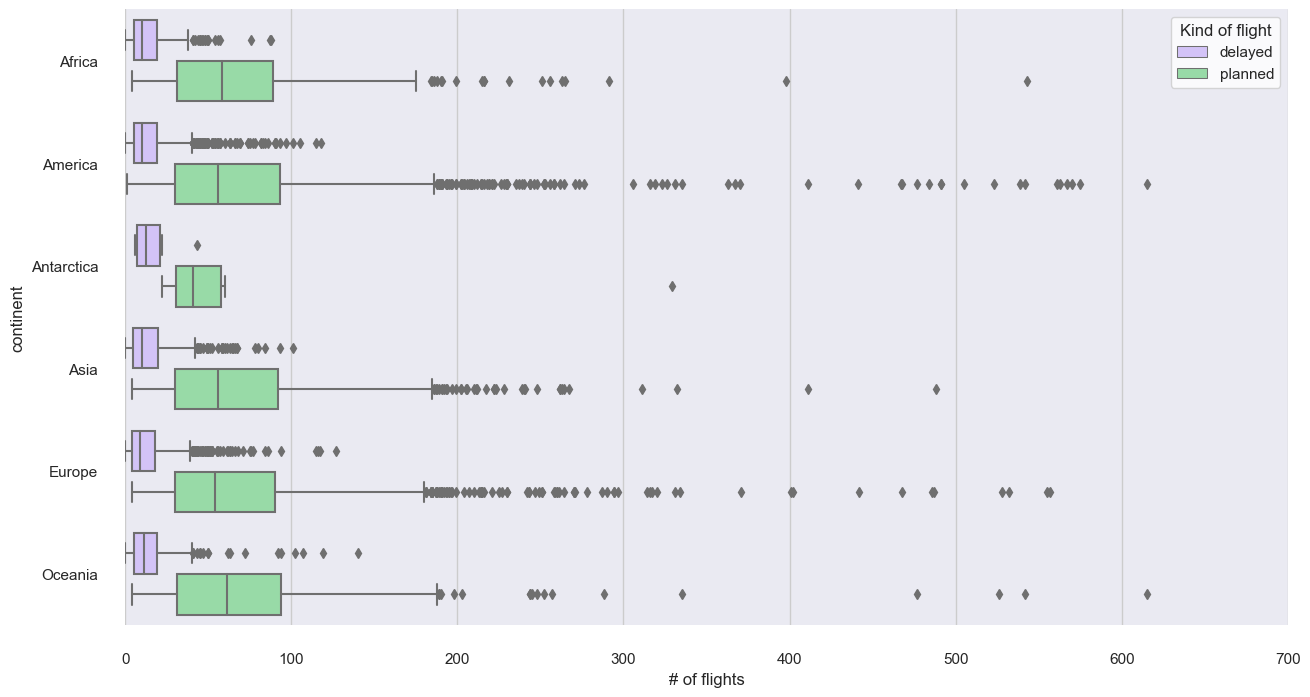

In [25]:
df_4_3 = df_del.loc[:, ['continent', 'flights_planned', 'flights_delayed']] \
    .rename(columns={'flights_planned': 'planned', 'flights_delayed': 'delayed'}) \
    .melt(id_vars=['continent'], value_vars=['planned', 'delayed'], var_name="Kind of flight", \
        value_name="# of flights") \
    .sort_values('continent')

f, ax1 = plt.subplots(figsize=(15, 8))

sns.set_theme(style="ticks", palette="pastel")

# Draw a nested boxplot to show bills by day and time
ax1.set(xlim=[0, 700])
sns.boxplot(x="# of flights", y="continent",
            hue="Kind of flight", palette=["m", "g"],
            data=df_4_3)
sns.despine(offset=10, trim=True)

I observe that in all continents there is a significant higher number of planned flights than the number of delayed flights. This can be determined by the inter-quartile range positions of both series' boxplots with respect to each other.

## Exercise 5 - Geospatial data analysis (35 points) 🌍

Use the ‘*airports’*, ‘*routes’*, ’*countries*’ and ’*europe.geojson*’ files. Create an interactive map representation - related to European countries only - such that, when a country is selected the map shows the number of flights left from the country selected and directed to each of the other countries, if flights with those destinations exist. The information should be represented as a choropleth map, essentially dynamically creating it when a country is selected.

**Hints**:
1. If `A` is a GeoDataFrame and `B` a DataFrame, the result of `A.merge(B,..)` is a GeoDataFrame, whereas the result of `B.merge(A,..)` is a DataFrame. The function `to_json()` on a DataFrame with a geometry column does **not** work.
2. When updating the map, to access the color mapper you can use the following method:
```
color_mapper = p.select_one(LinearColorMapper)
```
where `p` is the figure.

3. You can discard Guernsey and Gibraltar that are not present in the geojson.


<aside>
💡 Note that you have all the information you need in the files mentioned above. 
</aside>

In [26]:
df_air = pd.read_csv("./datasets/airports.csv", index_col='ID', na_values=['\\N'], dtype={'ID': pd.Int64Dtype()}) \
    .drop(columns=['latitude', 'longitude'])

# I am assuming each row of this data source should be counted as one flight
df_routes = pd.read_csv("./datasets/routes.csv", na_values=['\\N'], sep=";") \
    .rename(lambda x: x.strip(), axis=1)

# Note that I consider a country to be 'European' if the 'continent' country in countries.csv is equal to 'eu' 
df_countries = pd.read_csv("./datasets/countries.csv") 
df_countries = df_countries.loc[df_countries.continent == 'eu', :] \
    .rename(columns={'name': 'country'}).drop(columns=['continent'])

# This is the only country that has a different name in countries.csv compared to airports.csv
df_countries.loc[df_countries.country == 'Faroe Is.', 'country'] = 'Faroe Islands'

df_id_country = df_air.join(df_countries.set_index('country'), on='country', how='right', lsuffix='_air') \
    .reset_index(drop=True) \
    .loc[:, ['IATA', 'country']] \
    .set_index('IATA')

# Right join twice with source airport country and destination airport country
# A right join assures we include all countries in the final dataframe

# Note that I join on IATA codes instead of airport IDs as some airports have missing IDs. 
# This SHOULD be fine for the scope of this assignment, however on a worldwide scale IDs are
# preferrable as IATA codes may have overlaps. The author of this notebook advocates for the use
# of ICAO codes in datasets and to follow ISO and UN recommendations whenever practical, however this 
# is just my cup of ISO 3103.
df_routes_count = df_routes \
    .loc[:, ['source_airport', 'destination_airport']] \
    .join(df_id_country, how='right', on='source_airport') \
    .join(df_id_country, how='right', on='destination_airport', rsuffix='_dest')

# Count only a pair of notna source and destination airport as a valid flight
# When this is not a case the row is an artifact of the right join. We assign 0
# as a value so that in the final sum the value will still appear to include 
# no-flight countries, albeit with a total number of routes to 0
df_routes_count['# routes'] = 0
df_routes_count.loc[df_routes_count.source_airport.notna() & \
                    df_routes_count.destination_airport.notna(), '# routes'] = 1

# source of flights as rows, destination as columns
df_routes_count = df_routes_count \
    .groupby(['country', 'country_dest']).agg({'# routes': 'sum'}) \
    .rename(columns={0: '# routes'}) \
    .unstack() \
    .fillna(0) \
    .sort_values('country')

# Change type of cells to float and remove column level for geopandas compatibility
df_routes_count = df_routes_count[df_routes_count.columns].astype(float)
df_routes_count.columns = df_routes_count.columns.droplevel(0)
df_routes_count.head()

country_dest  Albania  Andorra  Austria  Belarus  Belgium  \
country                                                     
Albania           0.0      0.0      1.0      0.0      0.0   
Andorra           0.0      0.0      0.0      0.0      0.0   
Austria           1.0      0.0     15.0      2.0      2.0   
Belarus           0.0      0.0      2.0      0.0      0.0   
Belgium           0.0      0.0      2.0      0.0      1.0   

country_dest  Bosnia and Herzegovina  Bulgaria  Croatia  Czech Republic  \
country                                                                   
Albania                          0.0       0.0      0.0             0.0   
Andorra                          0.0       0.0      0.0             0.0   
Austria                          1.0       3.0      6.0             1.0   
Belarus                          0.0       0.0      0.0             2.0   
Belgium                          0.0       4.0      5.0             4.0   

country_dest  Denmark  ...  San Marino  Serbia  Slovakia  Slovenia  Spain  \
country                ...                                                  
Albania           0.0  ...         0.0     0.0       0.0       1.0    0.0   
Andorra           0.0  ...         0.0     0.0       0.0       0.0    0.0   
Austria           5.0  ...         0.0     3.0       1.0       2.0   40.0   
Belarus           0.0  ...         0.0     0.0       0.0       0.0    1.0   
Belgium           5.0  ...         0.0     2.0       1.0       3.0   57.0   

country_dest  Sweden  Switzerland  Ukraine  United Kingdom  Vatican City  
country                                                                   
Albania          0.0          0.0      0.0             1.0           0.0  
Andorra          0.0          0.0      0.0             0.0           0.0  
Austria          4.0         12.0     10.0            11.0           0.0  
Belarus          1.0          1.0      2.0             1.0           0.0  
Belgium          7.0          6.0      2.0            17.0           0.0  

[5 rows x 46 columns]

In [27]:
# Note the inner join to drop countries that we do not consider part of 'Europe'
# (according to the countries.csv file)
yurop = gpd.read_file("./datasets/europe.geojson") \
    .loc[:, ['NAME', 'geometry']] \
    .set_index('NAME') \
    .join(df_routes_count, how='inner') \
    .reset_index(names='NAME')

yurop.head()

NAME                                           geometry  \
0                 Albania  POLYGON ((19.43621 41.02107, 19.45055 41.06000...   
1  Bosnia and Herzegovina  POLYGON ((17.64984 42.88908, 17.57853 42.94382...   
2                Bulgaria  POLYGON ((27.87917 42.84110, 27.89500 42.80250...   
3                 Denmark  MULTIPOLYGON (((11.51389 54.82972, 11.56444 54...   
4                 Ireland  MULTIPOLYGON (((-9.65639 53.22222, -9.66333 53...   

   Albania  Andorra  Austria  Belarus  Belgium  Bosnia and Herzegovina  \
0      0.0      0.0      1.0      0.0      0.0                     0.0   
1      0.0      0.0      1.0      0.0      0.0                     2.0   
2      0.0      0.0      3.0      0.0      4.0                     0.0   
3      0.0      0.0      5.0      0.0      5.0                     1.0   
4      0.0      0.0      1.0      0.0      3.0                     0.0   

   Bulgaria  Croatia  ...  San Marino  Serbia  Slovakia  Slovenia  Spain  \
0       0.0      0.0  ...         0.0     0.0       0.0       1.0    0.0   
1       0.0      1.0  ...         0.0     3.0       0.0       1.0    0.0   
2       6.0      0.0  ...         0.0     2.0       0.0       0.0    8.0   
3       1.0      6.0  ...         0.0     2.0       0.0       2.0   31.0   
4       1.0      3.0  ...         0.0     0.0       1.0       0.0   53.0   

   Sweden  Switzerland  Ukraine  United Kingdom  Vatican City  
0     0.0          0.0      0.0             1.0           0.0  
1     3.0          1.0      0.0             0.0           0.0  
2     0.0          1.0      0.0            10.0           0.0  
3     9.0          7.0      0.0            22.0           0.0  
4     2.0          3.0      0.0            63.0           0.0  

[5 rows x 48 columns]

In [28]:
from bokeh.events import Tap
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler
from bokeh.palettes import Reds
from bokeh.models import LinearColorMapper, ColorBar
from shapely import Point
from bokeh.models import Title

output_notebook()

def figure_flights(doc):
    palette = Reds[8]
    palette = palette[::-1]

    color_mapper = LinearColorMapper(palette = palette, low = 0, high = 600)
    
    color_bar = ColorBar(color_mapper = color_mapper, 
                         width = 20, height = 600,
                         label_standoff = 8,
                         location = (0,0))

    
    p = figure(title = '', 
           frame_height = 600,
           frame_width = 800, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")

    geo_ds = GeoJSONDataSource()
    
    plotted_districts = p.patches('xs','ys', source = geo_ds,
                    line_color = 'black', 
                    line_width = 0.25)
    
    p.add_layout(Title(text="WARNING: color scale dynamically changes according to selected country", \
                       text_font_style="italic"), 'above')

    p.patches("xs","ys", source = geo_ds,
                   fill_color = {"field" : "flights",
                                 "transform" : color_mapper},
                   line_color = "gray", 
                   line_width = 0.25, 
                   fill_alpha = 1)
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.visible = False
    
    ht = HoverTool(renderers = [plotted_districts])
    p.add_tools(ht)
    
    # This function updates dynamically the dataset whenever a country is clicked
    # To be exact, the function changes
    # - The entire GeoJSON data source
    # - The plot title
    # - The color scale 'max' value
    # - The tooltips displayed for each country
    def set_gdf_as_datasource(gdf):
        
        if gdf is None or len(gdf) == 0:
            # If no country has been selected, reset the map
            geo_ds.geojson = yurop.to_json()
            ht.tooltips = [("Country", "@NAME")]
            color_mapper.high = 600
            p.title.text = '# flights to each country: click to select country of departure'
        else:
            # If a country 'c' has been selected, join the 'geometry' column of each country with the 
            # series of number of flights departing from 'c' and arriving in each country
            routes_from_country = gdf.iloc[0, 2:].to_frame(name='flights')
            gdf_country_flights = yurop.set_index('NAME').loc[:, ['geometry']] \
                .join(routes_from_country) \
                .reset_index(names='NAME')

            country = gdf.iloc[0, :]['NAME']
            max_flights = gdf_country_flights['flights'].max()
            
            geo_ds.geojson = gdf_country_flights.to_json()
            ht.tooltips = [("Country", "@NAME"), (f"# flights from {country}", "@flights")]
            p.title.text = f"# flights to each country from {country}: click to select another country of departure"
            
            # The max value of the colorscale is dynamically computed to the ceiling of the first two significant 
            # digits of the max value
            color_mapper.high = np.round(np.power(10, np.ceil(np.log10(max_flights) * 10) / 10) / 10) * 10
            
    set_gdf_as_datasource(None)

    tool = TapTool()
    
    def event(x):
        # Figure out the country that intersects the coordinates we clicked
        intersects = yurop[yurop.intersects(Point(x.x, x.y))]
        set_gdf_as_datasource(intersects)
        
    tap = p.add_tools()
    p.on_event(Tap, event)
    
    p.add_layout(color_bar, "right")
    doc.add_root(p)

handler = FunctionHandler(figure_flights)
app = Application(handler)

show(app)

Loading BokehJS ...

## Datasets description

### **Used Cars**

Please find the dataset in the datasets folder.

This dataset is scraped from Ebay. The content of the dataset is in German, but it should not impose critical issues in understanding the data. The fields included in the dataset are as following:

**dateCrawled**: when this ad was first crawled, all field-values are taken from this date\
**name**: ”name” of the car\
**seller**: private or dealer\
**offerTypeprice**: the price in euro on the ad to sell the car\
**abtestvehicleTypeyearOfRegistration** : at which year the car was first registered\
**gearboxpowerPS**: power of the car in PS\
**modelkilometer**: how many kilometers the car has driven\
**monthOfRegistration**: at which month the car was first registered\
**fuelType**: vehicle fuel type\
**brand**: vehicle brand\
**notRepairedDamage**: if the car has a damage which is not repaired yet\
**dateCreated**: the date for which the ad at ebay was created\
**nrOfPictures**: number of pictures in the ad\
**postalCodelastSeenOnline**: when the crawler saw this ad last online

### **Airports, Routes and Ariports Delays**

Please find the datasets in the datasets folder.

The datasets used in this section can be found in the datasets folder.
Datasets description are as follows.

### **Airports**

As of January 2017, the OpenFlights Airports Database contains over 10,000 airports, train stations and ferry terminals spanning the globe, as shown in the map above. Each entry contains the following information:

**Airport ID**: Unique OpenFlights identifier for this airport\
**Name**: Name of airport. May or may not contain the City name\
**City**: Main city served by airport. May be spelled differently from Name\
**Country**: Country or territory where airport is located. See Countries to cross-reference to ISO 3166-1 codes\
**IATA**: 3-letter IATA code. Null if not assigned/unknown\
**ICAO**: 4-letter ICAO code. Null if not assigned/unknown\
**Latitude**: Decimal degrees, usually to six significant digits. Negative is South, positive is North\
**Longitude**: Decimal degrees, usually to six significant digits. Negative is West, positive is East\
**Altitude**: In feet\
**Timezone**: Hours offset from UTC. Fractional hours are expressed as decimals, eg. India is 5.5\
**DST**: Daylight savings time. One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown)\
**Tz database time zone**: Timezone in "tz" (Olson) format, eg. "America/Los_Angeles"\
**Type**: Type of the airport. Value "airport" for air terminals\
**Source**: Source of the data. "OurAirports" for data sourced from OurAirports

### **Airports Delays**
**Airport ID**: Unique OpenFlights identifier for this airport\
**Name**: Name of airport. May or may not contain the City name\
**City**: Main city served by airport. May be spelled differently from Name\
**Country**: Country or territory where airport is located. See Countries to cross-reference to ISO 3166-1 codes\
**IATA**: 3-letter IATA code. Null if not assigned/unknown\
**ICAO**: 4-letter ICAO code. Null if not assigned/unknown\
**Latitude**: Decimal degrees, usually to six significant digits. Negative is South, positive is North\
**Longitude**: Decimal degrees, usually to six significant digits. Negative is West, positive is East\
**Altitude**: In feet\
**Timezone**: Hours offset from UTC. Fractional hours are expressed as decimals, eg. India is 5.5\
**DST**: Daylight savings time. One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown)\
**Tz database time zone**: Timezone in "tz" (Olson) format, eg. "America/Los_Angeles"\
**Type**: Type of the airport. Value "airport" for air terminals\
**Source**: Source of the data. "OurAirports" for data sourced from OurAirports\
**Flights planned**: The number of fligths the related airport planned\
**Flights cancelled**: The number of flights cancelled\
**Flights delayed**: The number of flights delayed\
**Delay duration**: The delay duration (in minutes)


### **Routes**

As of June 2014, the OpenFlights/Airline Route Mapper Route Database contains 67663 routes between 3321 airports on 548 airlines spanning the globe, as shown in the map above. Each entry contains the following information:

**Airline**: 2-letter (IATA) or 3-letter (ICAO) code of the airline\
**Airline ID**: Unique OpenFlights identifier for airline (see Airline)\
**Source airport**: 3-letter (IATA) or 4-letter (ICAO) code of the source airport\
**Source airport ID**: Unique OpenFlights identifier for source airport (see Airport)\
**Destination airport**: 3-letter (IATA) or 4-letter (ICAO) code of the destination airport\
**Destination airport ID**: Unique OpenFlights identifier for destination airport (see Airport)\
**Codeshare**: "Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise\
**Stops**: Number of stops on this flight ("0" for direct)\
**Equipment**: 3-letter codes for plane type(s) generally used on this flight, separated by spaces\
The data is UTF-8 encoded. The special value \N is used for "NULL" to indicate that no value is available, and is understood automatically by MySQL if imported


<aside>
💡 Notes:

- Routes are directional: if an airline operates services from A to B and from B to A, both A-B and B-A are listed separately.
- Routes where one carrier operates both its own and codeshare flights are listed only once.
</aside>


### **Countries**

Please find the dataset in the datasets folder.

This dataset contains the information related to European countries.
